In [1]:
import sys, os, io, json, numpy as np, random, time
#from sklearn.metrics import roc_auc_score
from importlib import reload
import extra_utils
reload(extra_utils)
from extra_utils import time_features, subpool, test_extra_predictions
import forest
reload(forest)
from forest import build_tree, EMatrix, tree2gv
import xgboost as xgb
import tensorflow as tf
import split
reload(split)
from split import SplitMaker
#from split import make_split_quick, make_gax, split_quick_graph, split_quick_graph_transpose
import graphviz
from sklearn import metrics

In [2]:
split_maker_old = SplitMaker.make_split_old()

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
pool = np.load('../prepare_dataset/pool_cross_00.npz')
features_bool, f_time, label_orig = (pool[name] for name in ['features', 'f_time', 'label'])
label = label_orig

In [4]:
np.random.seed(42)
features_orig = np.random.normal(loc=features_bool*1.0, scale=0.01)
#features = features[:150000,:]; label = label_orig[:150000, :]

f_test, l_test = features_orig[150000:,:], label_orig[150000:, :]
features = features_orig[:150000,:]; label = label_orig[:150000, :]

### Тестирование инвариантности сплита относительно замены местами столбцов фичей

```
features_swap = np.concatenate([features[:,7:8], features[:,1:7], features[:,0:1], features[:,8:]], axis=1)

%%time
split_maker_old.split(np.zeros(label.shape), features, label)
#make_split(np.zeros(label.shape), features, label)

%%time
split_maker_old.split(np.zeros(label.shape), features_swap, label)
#make_split(np.zeros(label.shape), features_swap, label)
```

In [5]:
features.shape, label.shape

((150000, 17), (150000, 1))

In [6]:
global_ax = split_maker_old.make_gax(features)
featuresT = features.T
global_axT = global_ax.T

In [7]:
split_maker = SplitMaker.make_split_new(reduce_axis=0, make_transpose=True)

In [8]:
%%time
start_params = {'max_depth': 8, 'learning_rate':0.3, 'transposed_feature': 1, 'unbalanced_penalty':0.001}
tf.constant
forest.time1 = forest.time2 =0
forest.time3 = []
with tf.Session(graph=split_maker.graph) as s:
    tree = build_tree(start_params, EMatrix(featuresT if split_maker.reduce_axis==1 else features, 
                                            label, bias=np.zeros(label.shape), 
                                            gax=global_axT if split_maker.reduce_axis==1 else global_ax, 
                                            splitgax=True), split_maker=split_maker, sess=s)
print("\nsplit time = {:.5f}, {:.5f}, [{}]".format(forest.time1, forest.time2, ", ".join("{:.5f}".format(tt) for tt in forest.time3)), file=sys.stderr)
tree_arrays = forest.init_arrays(tree, forest.init_id(tree))

Wall time: 4.04 s



split time = 3.87109, 0.11401, [0.44814, 0.10583, 0.08104, 0.06561, 0.06179, 0.04384, 0.04270, 0.03568, 0.01307, 0.01336, 0.01246, 0.01139, 0.02040, 0.01744, 0.01545, 0.01238, 0.01181, 0.01146, 0.01156, 0.01556, 0.01387, 0.01308, 0.01311, 0.01079, 0.01237, 0.01089, 0.01209, 0.01087, 0.01174, 0.01049, 0.01166, 0.01162, 0.01071, 0.01040, 0.01739, 0.01614, 0.01372, 0.01371, 0.01241, 0.01290, 0.01214, 0.01097, 0.01154, 0.01148, 0.01064, 0.01079, 0.01013, 0.01227, 0.01182, 0.01080, 0.01180, 0.01204, 0.01086, 0.01003, 0.01015, 0.01149, 0.01239, 0.01136, 0.01159, 0.01129, 0.01117, 0.01120, 0.01053, 0.01027, 0.01168, 0.03094, 0.02486, 0.01975, 0.01747, 0.01508, 0.01358, 0.01375, 0.01227, 0.01172, 0.01212, 0.01243, 0.01164, 0.01177, 0.01180, 0.01056, 0.01137, 0.01117, 0.01437, 0.01274, 0.01165, 0.01198, 0.01204, 0.01172, 0.01233, 0.01124, 0.01099, 0.01338, 0.01061, 0.01063, 0.01147, 0.01131, 0.01111, 0.01427, 0.01225, 0.01226, 0.01781, 0.01397, 0.01241, 0.01223, 0.01169, 0.01307, 0.01199, 0.01

In [9]:
import pstats
#p = pstats.Stats('build_tree.prof')
#p.sort_stats('tottime').print_stats()

In [10]:
pred = forest.tree_apply(tree_arrays, features)
pred_test = forest.tree_apply(tree_arrays, f_test)
auc1l = metrics.roc_auc_score(label[:, 0], pred)
auc1t = metrics.roc_auc_score(label[:, 0], pred_test)
auc0 = metrics.roc_auc_score(label[:, 0], np.zeros(label.shape[0]))
auc1l, auc1t, auc0

(0.6160966418118923, 0.49957753188510584, 0.5)

In [11]:
#tree.left.left.left.left.val, tree.val
tree.left.left

In [12]:
#forest.tree2gv(tree)

In [13]:
%%time
boost_params = {'max_depth': 4, 'learning_rate':0.3, 'splitgax': True, 'transposed_feature': 0, 'unbalanced_penalty':0.001}
booster = forest.train(boost_params, EMatrix(featuresT if boost_params['transposed_feature'] else features, label), num_boost_round=10)

Wall time: 9.33 s


In [14]:
####################################################

In [15]:
#%%time
#gax13 = make_gax(features)
#print(gax13.shape)

In [16]:
pred2 = booster.predict(features)
pred2b = booster.predict(features, tree_limit=10)
pred_test = booster.predict(f_test)
main_auc_l = metrics.roc_auc_score(label[:, 0], pred2)
main_auc_t = metrics.roc_auc_score(l_test[:, 0], pred_test)
main_auc_l, main_auc_t

(0.6504761784901035, 0.6463948363469747)

In [17]:
0.5783850422568331,0.547297544877569

(0.5783850422568331, 0.547297544877569)

In [18]:
#np.min(pred2b), np.max(pred2b)

In [19]:
if False:
    tree2gv(booster.forest[45][0])

In [20]:
dmat = xgb.DMatrix(features, label)

In [21]:
%%time
params = {'max_depth': 4, 'objective': 'binary:logistic', 'eta': 0.3, 'tree_method': 'exact', 'lambda': 1}
model = xgb.train(params, dmat, num_boost_round=10)

Wall time: 791 ms


In [22]:
dmat_test = xgb.DMatrix(f_test, l_test)

In [23]:
pred_fast = model.predict(dmat)
pred_test = model.predict(dmat_test)

metrics.roc_auc_score(label[:, 0], pred_fast), metrics.roc_auc_score(l_test[:, 0], pred_test)

(0.6512252339267851, 0.647475708740195)

In [24]:
pred_fast = model.predict(dmat, ntree_limit=35)
metrics.roc_auc_score(label[:, 0], pred_fast)

0.6512252339267851

In [25]:
pred2b = booster.predict(features, tree_limit=15)
metrics.roc_auc_score(label[:, 0], pred2b)

0.6504761784901035

In [26]:
0.5987831226886691, 0.5457320402572653

(0.5987831226886691, 0.5457320402572653)

In [27]:
qq = -np.log(1/pred_fast-1) 
np.min(qq), np.max(qq)

(-3.4156384, -0.31315148)

In [28]:
diff = np.abs(qq - pred2b)
np.mean(diff > 0.1)

0.3170866666666667

In [29]:
model.dump_model('xgb.dump')

In [30]:
#tree2gv(booster.forest[1][0])

In [31]:
!cat xgb.dump | tail -n+$(echo 39*31+31 | bc) | head -n 100

"cat" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


### Extra begins here

In [32]:
extra_f = time_features(f_time, feat_num=2)

In [33]:
extra_f.shape

(300000, 2)

In [34]:
N = 300000
f_spec = np.random.normal(loc=np.zeros((N,2)))
time_spec = np.random.uniform(size=(N,1)) #loc=np.zeros((N,1)))
print(time_spec.shape)
label_spec = ((f_spec[:, 0:1] + 3 * f_spec[:, 1:2] * (time_spec[:, 0:1] - 0.5))  > 0) * 1
extra_spec = time_features(time_spec, feat_num=2)

(300000, 1)


In [35]:
#f_spec[:10]

In [36]:
features_orig_cut = features_orig #[:,0:8]
f_train, extra_f_train, label_train = subpool((features_orig_cut, extra_f, label_orig), f_time, (0, 0.5)) #0.33
f_train, extra_f_train, label_train = f_train[:40000,:], extra_f_train[:40000,:], label_train[:40000,:]
time_column = f_time
full_features = features_orig_cut
full_extra_features = extra_f
full_label = label_orig
if 0:
    f_train, extra_f_train, label_train = subpool((f_spec, extra_spec, label_spec), time_spec, (0, 0.2))
    time_column = time_spec 
    full_features = f_spec
    full_extra_features = extra_spec
    full_label = label_spec

In [37]:
#cond = np.logical_and.reduce([f_train[:,k] > 0.016 for k in [1,2,3,5]])
#cond = f_train[:,1] > 0.016
#cond1 = extra_f_train[:,1] < 0.25
#cond2 = np.logical_not(cond1)

In [38]:
if False:
    (np.mean(label_train[np.logical_and(cond, cond1)]) / np.mean(label_train[:,0]),
     np.mean(label_train[np.logical_and(cond, cond2)]) / np.mean(label_train[:,0])
    )

In [39]:
cond = features_orig[:,1] < 0.5
cond1 = f_time[:,0] < 0.05
cond2 = np.logical_not(cond1)
(np.mean(label_orig),
 np.mean(label_orig[np.logical_and(cond, cond1)]),
 np.mean(label_orig[np.logical_and(cond, cond2)])
)

(0.29917333333333335, 0.29016071558432116, 0.30777149769871376)

In [40]:
#np.concatenate((f_train[:20, 1:2], label_train[:20, 0:1], extra_f_train[:20, :1]), axis=1)

In [41]:
f_train.shape, extra_f_train.shape, label_train.shape

((40000, 17), (40000, 2), (40000, 1))

In [42]:
import extra_utils
reload(extra_utils)
from extra_utils import time_features, subpool, test_extra_predictions
import forest
reload(forest)
from forest import build_tree, EMatrix, tree2gv
import split
reload(split)
from split import SplitMaker
import ipywidgets
from ipywidgets import IntProgress
from IPython.display import display, clear_output, Markdown

In [43]:
#ipywidgets.IntProgress(min=0, max=rounds, value=0)

In [45]:
%%time
rounds = 400
progress = ipywidgets.IntProgress(min=0, max=rounds, value=0)
#display(progress)
def progress_callback(value, max):
    progress.value = value
    progress.max = max
    clear_output()
    l = 100
    x = int(value*l/max + 0.5)
    y = l-x
    display(Markdown('<span style="font-family:Courier">' + '[' + ('#' * x) + ('-' * y) + ']' + '{x}/{m}'.format(x=x,m=max) + '</span>'))
    #display(progress)

boost_params = {'max_depth': 4, 'learning_rate':0.03, 'splitgax': True, 'transposed_feature': 1, 'unbalanced_penalty':0.00001,
               'progress_callback': progress_callback}
if True:
    booster_regular = forest.train(boost_params, EMatrix(features=f_train.T if boost_params['transposed_feature'] else  f_train, 
                                                 extra_features=None,
                                                 label=label_train), num_boost_round=rounds)
if False:
    booster = forest.train(boost_params, EMatrix(features=f_train.T if boost_params['transposed_feature'] else  f_train, 
                                             extra_features=extra_f_train.T if boost_params['transposed_feature'] else extra_f_train,
                                             label=label_train), num_boost_round=rounds)

<span style="font-family:Courier">[####################################################################################################]100/400</span>

Wall time: 5min 35s


In [46]:
whole_prediction = booster.predict(full_features, extra_features=full_extra_features, tree_limit=3000)
#test_extra_predictions(20, time_column, full_label, whole_prediction)

In [47]:
test_extra_predictions(50, time_column, full_label, whole_prediction)

(0.0, 0.02) score = 0.8756750118127068
(0.02, 0.04) score = 0.8642617877921127
(0.04, 0.06) score = 0.8477389349783392
(0.06, 0.08) score = 0.8245432032124177
(0.08, 0.1) score = 0.8193920143261757
(0.1, 0.12) score = 0.8089868920219692
(0.12, 0.14) score = 0.7802068520916018
(0.14, 0.16) score = 0.8013614553214664
(0.16, 0.18) score = 0.7639268662244519
(0.18, 0.2) score = 0.7594336181498728
(0.2, 0.22) score = 0.7474790019394784
(0.22, 0.24) score = 0.7269357537427258
(0.24, 0.26) score = 0.723626613346379
(0.26, 0.28) score = 0.7050353898962477
(0.28, 0.3) score = 0.7076953002310875
(0.3, 0.32) score = 0.6759548126847766
(0.32, 0.34) score = 0.6688334979990036
(0.34, 0.36) score = 0.6574033456161898
(0.36, 0.38) score = 0.646351162327469
(0.38, 0.4) score = 0.6440924794020363
(0.4, 0.42) score = 0.638414685097404
(0.42, 0.44) score = 0.62929143297466
(0.44, 0.46) score = 0.6121024067956583
(0.46, 0.48) score = 0.615854559328678
(0.48, 0.5) score = 0.5956050749544597
(0.5, 0.52) scor

In [48]:
whole_prediction_regular = booster_regular.predict(full_features, tree_limit=1000)

In [49]:
test_extra_predictions(50, time_column, full_label, whole_prediction_regular)

(0.0, 0.02) score = 0.9084203169984046
(0.02, 0.04) score = 0.8946320451118719
(0.04, 0.06) score = 0.8725678327552374
(0.06, 0.08) score = 0.8505799707986356
(0.08, 0.1) score = 0.8453368192276831
(0.1, 0.12) score = 0.8347712473812354
(0.12, 0.14) score = 0.8049895738268565
(0.14, 0.16) score = 0.8174015274889204
(0.16, 0.18) score = 0.7855266507289806
(0.18, 0.2) score = 0.7785873188720464
(0.2, 0.22) score = 0.7660019925970744
(0.22, 0.24) score = 0.7443783134642946
(0.24, 0.26) score = 0.7447961770744004
(0.26, 0.28) score = 0.7202349591924113
(0.28, 0.3) score = 0.7218919836506749
(0.3, 0.32) score = 0.6881685910169673
(0.32, 0.34) score = 0.6862524626774054
(0.34, 0.36) score = 0.6688670128198992
(0.36, 0.38) score = 0.6542720125718124
(0.38, 0.4) score = 0.6557348370626235
(0.4, 0.42) score = 0.6537834580374602
(0.42, 0.44) score = 0.6286593030023253
(0.44, 0.46) score = 0.6137670415814588
(0.46, 0.48) score = 0.6108014987024196
(0.48, 0.5) score = 0.5838413408469724
(0.5, 0.52

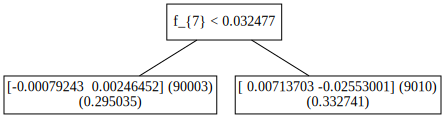

In [180]:
tree2gv(booster.forest[190][0])

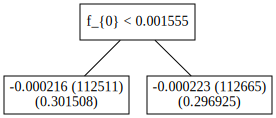

In [132]:
tree2gv(booster_regular.forest[160][0])

In [ ]:
def sigm(x):
    return 1/(1 + np.exp(-x))

In [105]:
freq = {}
for v in sigm(whole_prediction):
    freq[v] = freq.get(v, 0) + 1
freq

{0.26721492: 982,
 0.27964613: 3750,
 0.28262532: 26244,
 0.28485507: 1691,
 0.28536656: 29,
 0.28741762: 2932,
 0.28744617: 106,
 0.29536593: 5229,
 0.29722634: 20,
 0.2974511: 5,
 0.30088168: 78,
 0.3010206: 237294,
 0.3012496: 13331,
 0.3023119: 80,
 0.30651802: 2032,
 0.30738217: 1277,
 0.30917397: 4838,
 0.38645455: 5,
 0.39314502: 45,
 0.50112784: 32}

In [36]:
## xgboost

In [50]:
dmat = xgb.DMatrix((f_train > 0.5)*1, label_train)
params = {'max_depth': 4, 'objective': 'binary:logistic', 'eta': 0.03, 'tree_method': 'exact', 'lambda': 1}
model = xgb.train(params, dmat, num_boost_round=300)

In [70]:
#all_pred = model.predict(xgb.DMatrix(full_features[:,1:2]))
all_pred = model.predict(xgb.DMatrix(full_features))

In [53]:
test_extra_predictions(50, time_column, full_label, all_pred)

(0.0, 0.02) score = 0.9032507845673013
(0.02, 0.04) score = 0.8902447945310012
(0.04, 0.06) score = 0.8679600946087547
(0.06, 0.08) score = 0.8439194303672234
(0.08, 0.1) score = 0.8444182515264071
(0.1, 0.12) score = 0.832200328407225
(0.12, 0.14) score = 0.7970025415455143
(0.14, 0.16) score = 0.8106866179543925
(0.16, 0.18) score = 0.7795879322536112
(0.18, 0.2) score = 0.770471984875106
(0.2, 0.22) score = 0.7634956345540689
(0.22, 0.24) score = 0.7377234507077044
(0.24, 0.26) score = 0.7373824655489873
(0.26, 0.28) score = 0.7131037656216233
(0.28, 0.3) score = 0.7146482522249393
(0.3, 0.32) score = 0.6857830058599107
(0.32, 0.34) score = 0.6798795439767766
(0.34, 0.36) score = 0.6645083268196972
(0.36, 0.38) score = 0.6498420065489554
(0.38, 0.4) score = 0.6433744747706149
(0.4, 0.42) score = 0.64452536308601
(0.42, 0.44) score = 0.6241322307762116
(0.44, 0.46) score = 0.6062362356457448
(0.46, 0.48) score = 0.6015451152002438
(0.48, 0.5) score = 0.5777706100137008
(0.5, 0.52) sc

In [84]:
set(all_pred)

{0.28071296, 0.30143696}

In [88]:
label_train[f_train < 0.5].mean()

0.3014155326009728

In [96]:
label_train[f_train > 0.001564].mean()

0.29691010986473404

In [99]:
np.logical_and(f_train > 0.001564, f_train < 0.5).sum()

88684

# XGBoost with time

In [52]:
extra_f_train[:,1:]

array([[0.15705398],
       [0.09550877],
       [0.1379392 ],
       ...,
       [0.22165758],
       [0.080134  ],
       [0.1798147 ]])

In [53]:
extra_f_train[:,1:].shape, f_train.shape, full_features.shape, time_column.shape

((40000, 1), (40000, 17), (300000, 17), (300000, 1))

In [58]:
f_train_full = np.concatenate([(f_train > 0.5)*1, extra_f_train[:,1:]], axis=1)
dmat2 = xgb.DMatrix(f_train_full, label_train)
params2 = {'max_depth': 1, 'objective': 'binary:logistic', 'eta': 0.03, 'tree_method': 'exact', 'lambda': 1}
model2 = xgb.train(params2, dmat2, num_boost_round=300)

In [59]:
model2.dump_model('model3_depth1.txt')

In [60]:
all_conc_features = np.concatenate([full_features, time_column], axis=1)
print(all_conc_features.shape, f_train_full.shape)
all_pred2 = model2.predict(xgb.DMatrix(all_conc_features))

(300000, 18) (40000, 18)


In [61]:
test_extra_predictions(50, time_column, full_label, all_pred2)

(0.0, 0.02) score = 0.9036353002248968
(0.02, 0.04) score = 0.8886094102354269
(0.04, 0.06) score = 0.8696305522232226
(0.06, 0.08) score = 0.8454579508117932
(0.08, 0.1) score = 0.838912690568424
(0.1, 0.12) score = 0.8298505180907083
(0.12, 0.14) score = 0.7965490826028822
(0.14, 0.16) score = 0.8120186218075629
(0.16, 0.18) score = 0.7786188760564329
(0.18, 0.2) score = 0.7720886917367573
(0.2, 0.22) score = 0.762385973049412
(0.22, 0.24) score = 0.733626827457114
(0.24, 0.26) score = 0.7362062982220047
(0.26, 0.28) score = 0.7129607309492052
(0.28, 0.3) score = 0.716076659839441
(0.3, 0.32) score = 0.6846177809595334
(0.32, 0.34) score = 0.6817557582643003
(0.34, 0.36) score = 0.6666433372149287
(0.36, 0.38) score = 0.6545243090400946
(0.38, 0.4) score = 0.6466118316924152
(0.4, 0.42) score = 0.646567438796545
(0.42, 0.44) score = 0.621583468598913
(0.44, 0.46) score = 0.6081909050390646
(0.46, 0.48) score = 0.6018855531399196
(0.48, 0.5) score = 0.576269018166599
(0.5, 0.52) score

# Extra
```
(0.0, 0.05) score = 0.9068413383176274
(0.05, 0.1) score = 0.8642086729272381
(0.1, 0.15) score = 0.832215325762499
(0.15, 0.2) score = 0.7990991923044337
(0.2, 0.25) score = 0.7668029905200986
(0.25, 0.3) score = 0.7428440859467602
(0.3, 0.35) score = 0.6957277543619499
(0.35, 0.4) score = 0.6467537742860442
(0.4, 0.45) score = 0.6249159650710193
(0.45, 0.5) score = 0.5791989380077769
(0.5, 0.55) score = 0.5529901357400555
(0.55, 0.6) score = 0.5416803966490643
(0.6, 0.65) score = 0.5451087025830995
(0.65, 0.7) score = 0.5643833437278583
(0.7, 0.75) score = 0.5855574043833298
(0.75, 0.8) score = 0.6112285179936406
(0.8, 0.85) score = 0.6321717976410525
(0.85, 0.9) score = 0.6551836531039608
(0.9, 0.95) score = 0.6847527445853562
(0.95, 1.0) score = 0.7052528039481596
```
#Regular
```
(0.0, 0.05) score = 0.9052449072601721
(0.05, 0.1) score = 0.8641815054148507
(0.1, 0.15) score = 0.833742432196764
(0.15, 0.2) score = 0.8007202140173989
(0.2, 0.25) score = 0.7668997411738151
(0.25, 0.3) score = 0.7395679204824335
(0.3, 0.35) score = 0.6899635303167122
(0.35, 0.4) score = 0.6464169031826176
(0.4, 0.45) score = 0.6282158943231748
(0.45, 0.5) score = 0.583433465146161
(0.5, 0.55) score = 0.5481882973058844
(0.55, 0.6) score = 0.5316156558057219
(0.6, 0.65) score = 0.50536070449434
(0.65, 0.7) score = 0.4834392140249707
(0.7, 0.75) score = 0.45083100015374866
(0.75, 0.8) score = 0.42315518724857126
(0.8, 0.85) score = 0.4040687431620582
(0.85, 0.9) score = 0.38447350387423807
(0.9, 0.95) score = 0.3606301935437613
(0.95, 1.0) score = 0.33868745216225027
```